In [ ]:
%pip install emukit
from emukit.core import ContinuousParameter, ParameterSpace
import matplotlib as plt
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

In [12]:
import pandas as pd
import numpy as np
import gc
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt


# Load dataset

In [ ]:
df = pd.read_csv("./CASP15_global_error.csv")

In [ ]:
df

,AL0_P,TM-score,TM-align,AL4_P,QCS,Z-score,Handed.,SS,DFM,GDT_TS
0,77.78,0.794,0.797,88.89,87.09,7.43,0.91,0.463,0.17,76.92
1,36.47,0.410,0.444,41.76,53.52,2.81,0.91,0.520,0.37,38.38
2,72.17,0.888,0.893,87.39,97.86,12.90,0.94,0.650,0.09,70.54
3,95.50,0.921,0.924,98.20,97.10,8.25,0.95,0.678,0.04,91.89
4,57.27,0.571,0.569,64.55,67.85,3.86,0.92,0.462,0.22,55.45
...,...,...,...,...,...,...,...,...,...,...
3999,95.50,0.929,0.932,98.20,97.33,8.25,0.95,0.694,0.04,92.57
4000,95.93,0.972,0.972,96.83,99.00,10.91,0.97,0.780,0.05,96.49
4001,95.50,0.943,0.946,98.20,97.77,8.25,0.96,0.698,0.04,95.05
4002,0.00,0.388,0.405,0.00,26.25,0.84,0.80,0.204,0.32,48.33


In [ ]:
stats = df.describe()
stats

,AL0_P,TM-score,TM-align,AL4_P,QCS,Z-score,Handed.,SS,DFM,GDT_TS
count,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000
mean,70.993679,0.739573,0.745745,78.432403,82.152048,6.980502,0.902587,0.564950,0.237545,72.530145
std,26.351493,0.221429,0.217037,25.011285,21.180742,3.657681,0.094822,0.149368,0.333540,21.737269
min,0.000000,0.121000,0.178000,0.000000,8.790000,-2.350000,0.520000,0.054000,0.010000,10.910000
25%,57.270000,0.578000,0.578000,65.270000,73.860000,4.080000,0.900000,0.473000,0.050000,58.550000
50%,75.650000,0.825000,0.830000,89.740000,91.480000,8.060000,0.940000,0.562000,0.080000,78.480000
75%,95.500000,0.930000,0.932000,96.830000,97.660000,9.730000,0.960000,0.686000,0.250000,91.670000
max,99.400000,0.983000,0.983000,100.000000,99.230000,13.900000,0.980000,0.794000,1.800000,97.920000


In [ ]:
seed_values = [45,46,47,48,49,50]

In [ ]:
def scale_data(option,df):
  if option ==1:
    arr_scaled = df.drop('GDT_TS', axis=1).to_numpy()
    arr_scaled
  elif option ==2:
    scaler = MinMaxScaler()
    scaler.fit(df.drop('GDT_TS', axis=1))
    arr_scaled = scaler.transform(df.drop('GDT_TS', axis=1))
    arr_scaled
  else:
    scaler = StandardScaler()
    scaler.fit(df.drop('GDT_TS', axis=1))
    arr_scaled = scaler.transform(df.drop('GDT_TS', axis=1))
    arr_scaled

  df_scaled = pd.DataFrame(data=arr_scaled, columns=df.drop('GDT_TS', axis=1).columns)
  stats = df_scaled.describe()
  return arr_scaled,stats

In [ ]:
def sensitivity_analysis(df,arr_scaled,seed_values,stats):
  main_effects_list = []
  total_effects_list = []

  for seed_value in seed_values:
      np.random.seed(seed_value)

      # space = ParameterSpace([ContinuousParameter('x1', 2000, 50000),
      #                         ContinuousParameter('x2', 400, 16000)])

      space = ParameterSpace([ContinuousParameter(feat, stats[feat].loc['min'], stats[feat].loc['max']) for feat in stats.columns])

      Y = df['GDT_TS'].to_numpy().reshape(-1,1)
      #Y.shape
      X = arr_scaled
      #X.shape

      model_gpy = GPRegression(X,Y)
      model_emukit = GPyModelWrapper(model_gpy)
      model_emukit.optimize()

      senstivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
      main_effects, total_effects, _ = senstivity.compute_effects(num_monte_carlo_points = 10000)
      #main_effects_minmaxscaler, total_effects_minmaxscaler, _ = senstivity.compute_effects(num_monte_carlo_points = 10000)
      #main_effects_stdscaler, total_effects_stdscaler, _ = senstivity.compute_effects(num_monte_carlo_points = 10000)

      print(f"Seed {seed_value}, main effects:", main_effects)
      print(f"Seed {seed_value}, total effects:", total_effects)

      main_effects_list.append(main_effects)
      total_effects_list.append(total_effects)
      del(model_gpy)
      del(model_emukit)
      del(senstivity)
      gc.collect()
  return main_effects_list,total_effects_list



In [ ]:
def effects_list_to_df(effects_list):
    feats = effects_list[0].keys()

    feat_values = []
    for dic in effects_list:
        feat_values.append([val[0] for feat, val in dic.items()])

    feat_values = np.array(feat_values)
    df = pd.DataFrame(data=feat_values, columns=feats)

    return df

#Without Scaling

In [ ]:
arr_scaled,stats = scale_data(1,df)
main_effects_list,total_effects_list = sensitivity_analysis(df,arr_scaled,seed_values,stats)
df_main_effects = effects_list_to_df(main_effects_list)
df_main_effects.to_csv('main_effects_ws.csv', index=False)

df_total_effects = effects_list_to_df(total_effects_list)
df_total_effects.to_csv('total_effects_ws.csv', index=False)

Seed 45, main effects: {'AL0_P': array([0.00186046]), 'TM-score': array([0.00387677]), 'TM-align': array([0.00573047]), 'AL4_P': array([0.11341231]), 'QCS': array([0.0719706]), 'Z-score': array([0.00092705]), 'Handed.': array([0.00471145]), 'SS': array([0.00461757]), 'DFM': array([0.00716536])}
Seed 45, total effects: {'AL0_P': array([0.662088]), 'TM-score': array([0.00500053]), 'TM-align': array([0.00018816]), 'AL4_P': array([0.77595268]), 'QCS': array([0.66169462]), 'Z-score': array([0.21926821]), 'Handed.': array([-0.00224272]), 'SS': array([-0.00125954]), 'DFM': array([0.00824545])}
Seed 46, main effects: {'AL0_P': array([0.02250263]), 'TM-score': array([-0.00922784]), 'TM-align': array([-0.00825169]), 'AL4_P': array([0.09070306]), 'QCS': array([0.05249323]), 'Z-score': array([-0.00738586]), 'Handed.': array([-0.00948947]), 'SS': array([-0.01022715]), 'DFM': array([-0.00694665])}
Seed 46, total effects: {'AL0_P': array([0.72654979]), 'TM-score': array([0.0036304]), 'TM-align': arra

# Min Max

In [ ]:
arr_scaled,stats = scale_data(2,df)
main_effects_list,total_effects_list = sensitivity_analysis(df,arr_scaled,seed_values,stats)
df_main_effects = effects_list_to_df(main_effects_list)
df_main_effects.to_csv('main_effects_mm.csv', index=False)

df_total_effects = effects_list_to_df(total_effects_list)
df_total_effects.to_csv('total_effects_mm.csv', index=False)

Seed 45, main effects: {'AL0_P': array([0.02064432]), 'TM-score': array([0.03934614]), 'TM-align': array([0.03308379]), 'AL4_P': array([0.05140924]), 'QCS': array([0.00843242]), 'Z-score': array([0.0380231]), 'Handed.': array([0.0074656]), 'SS': array([0.00792133]), 'DFM': array([0.03065728])}
Seed 45, total effects: {'AL0_P': array([0.30711672]), 'TM-score': array([0.36486613]), 'TM-align': array([0.33882286]), 'AL4_P': array([0.35095541]), 'QCS': array([0.27340324]), 'Z-score': array([0.324429]), 'Handed.': array([0.23507973]), 'SS': array([0.21660541]), 'DFM': array([0.31320994])}
Seed 46, main effects: {'AL0_P': array([0.02949528]), 'TM-score': array([0.04933283]), 'TM-align': array([0.02402342]), 'AL4_P': array([0.03909337]), 'QCS': array([0.01228141]), 'Z-score': array([0.03699857]), 'Handed.': array([0.01046892]), 'SS': array([0.0209333]), 'DFM': array([0.04054574])}
Seed 46, total effects: {'AL0_P': array([0.37255697]), 'TM-score': array([0.43304697]), 'TM-align': array([0.4303

# Standard Scalling

In [ ]:
arr_scaled,stats = scale_data(2,df)
main_effects_list,total_effects_list = sensitivity_analysis(df,arr_scaled,seed_values,stats)
df_main_effects = effects_list_to_df(main_effects_list)
df_main_effects.to_csv('main_effects_ss.csv', index=False)

df_total_effects = effects_list_to_df(total_effects_list)
df_total_effects.to_csv('total_effects_ss.csv', index=False)

Seed 45, main effects: {'AL0_P': array([0.02064432]), 'TM-score': array([0.03934614]), 'TM-align': array([0.03308379]), 'AL4_P': array([0.05140924]), 'QCS': array([0.00843242]), 'Z-score': array([0.0380231]), 'Handed.': array([0.0074656]), 'SS': array([0.00792133]), 'DFM': array([0.03065728])}
Seed 45, total effects: {'AL0_P': array([0.30711672]), 'TM-score': array([0.36486613]), 'TM-align': array([0.33882286]), 'AL4_P': array([0.35095541]), 'QCS': array([0.27340324]), 'Z-score': array([0.324429]), 'Handed.': array([0.23507973]), 'SS': array([0.21660541]), 'DFM': array([0.31320994])}
Seed 46, main effects: {'AL0_P': array([0.02949528]), 'TM-score': array([0.04933283]), 'TM-align': array([0.02402342]), 'AL4_P': array([0.03909337]), 'QCS': array([0.01228141]), 'Z-score': array([0.03699857]), 'Handed.': array([0.01046892]), 'SS': array([0.0209333]), 'DFM': array([0.04054574])}
Seed 46, total effects: {'AL0_P': array([0.37255697]), 'TM-score': array([0.43304697]), 'TM-align': array([0.4303

# Plotting data

Get dataframe of collumn Average

In [5]:
def average_std(df):
  average_values = df.mean()
  average_df = pd.DataFrame(average_values)
  average_df = average_df.T
  average_df.columns = df.columns

  std_dev_values = df.std()
  std_dev_df = pd.DataFrame(std_dev_values)
  std_dev_df = std_dev_df.T
  std_dev_df.columns = df.columns
  std_dev_df

  return average_df,std_dev_df

In [23]:
def plot_mean_std(average_df,std_dev_df,title,path):

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(average_df.columns, average_df.iloc[0], yerr=std_dev_df.iloc[0], capsize=5, label='Values with Std Dev')
    # Adding labels and title
    ax.set_xlabel('Parameters')
    ax.set_ylabel('Values')
    ax.set_title(title)

    # Show the plot
    plt.show()
    plt.savefig(path, format='pdf', bbox_inches='tight')



# Plotting No Scalling

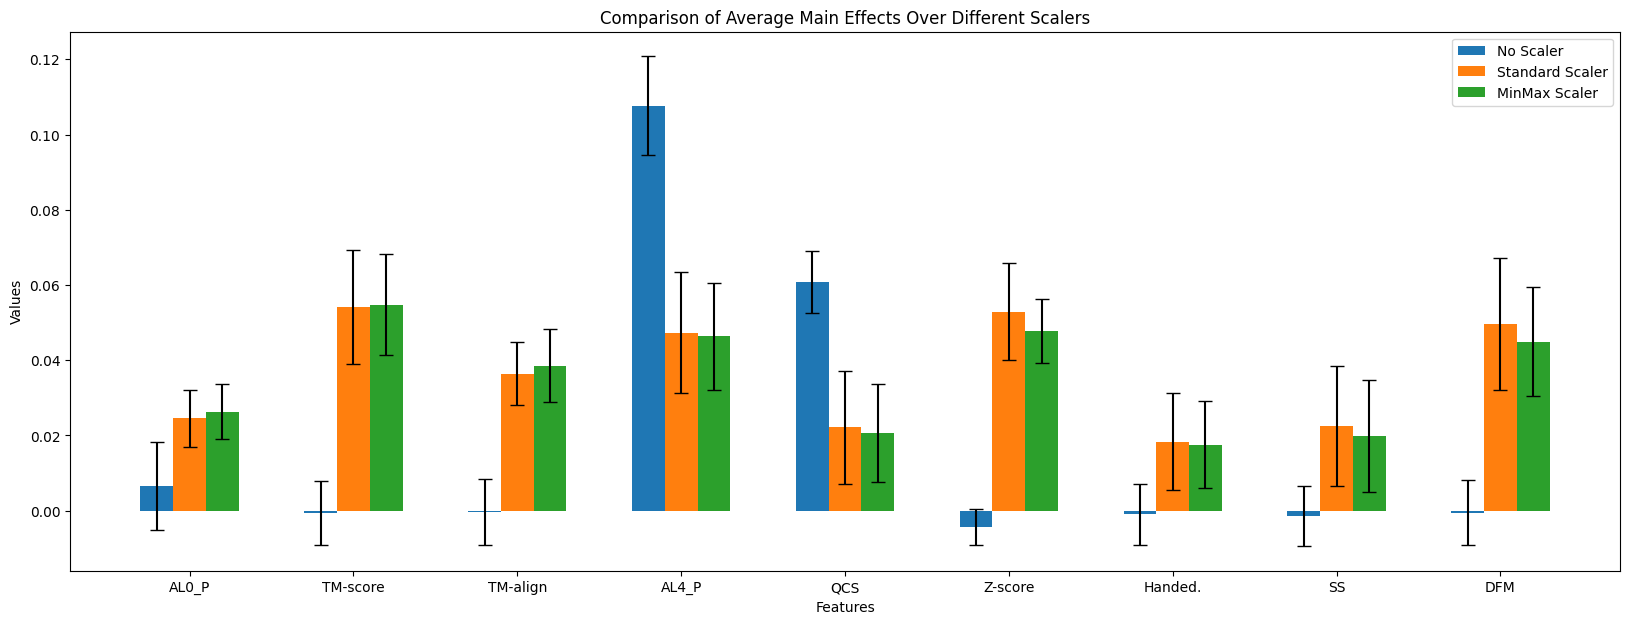

In [30]:
main_effects = pd.read_csv("./main_effects.csv")
main_effects_average_df,main_effects_std_dev_df = average_std(df)

main_effects_ss = pd.read_csv("./main_effects_stdscaler.csv")
main_effects_ss_average_df,main_effects_ss_std_dev_df = average_std(main_effects_ss)

main_effects_mm = pd.read_csv("./main_effects_minmaxscaler.csv")
main_effects_mm_average_df,main_effects_mm_std_dev_df = average_std(main_effects_mm)


fig, ax = plt.subplots(figsize=(20, 7))


bar_width = 0.2
bar_positions = np.arange(len(main_effects_average_df.columns))
ax.bar(bar_positions - bar_width, main_effects_average_df.iloc[0], width=bar_width, yerr=main_effects_std_dev_df.iloc[0], capsize=5, label='No Scaler')
ax.bar(bar_positions, main_effects_ss_average_df.iloc[0], width=bar_width, yerr=main_effects_ss_std_dev_df.iloc[0], capsize=5, label='Standard Scaler')
ax.bar(bar_positions + bar_width, main_effects_mm_average_df.iloc[0], width=bar_width, yerr=main_effects_mm_std_dev_df.iloc[0], capsize=5, label='MinMax Scaler')

ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Comparison of Average Main Effects Over Different Scalers')

ax.set_xticks(bar_positions)
ax.set_xticklabels(main_effects_average_df.columns)
ax.legend()

plt.savefig('main_effects.pdf', format='pdf', bbox_inches='tight')

plt.show()


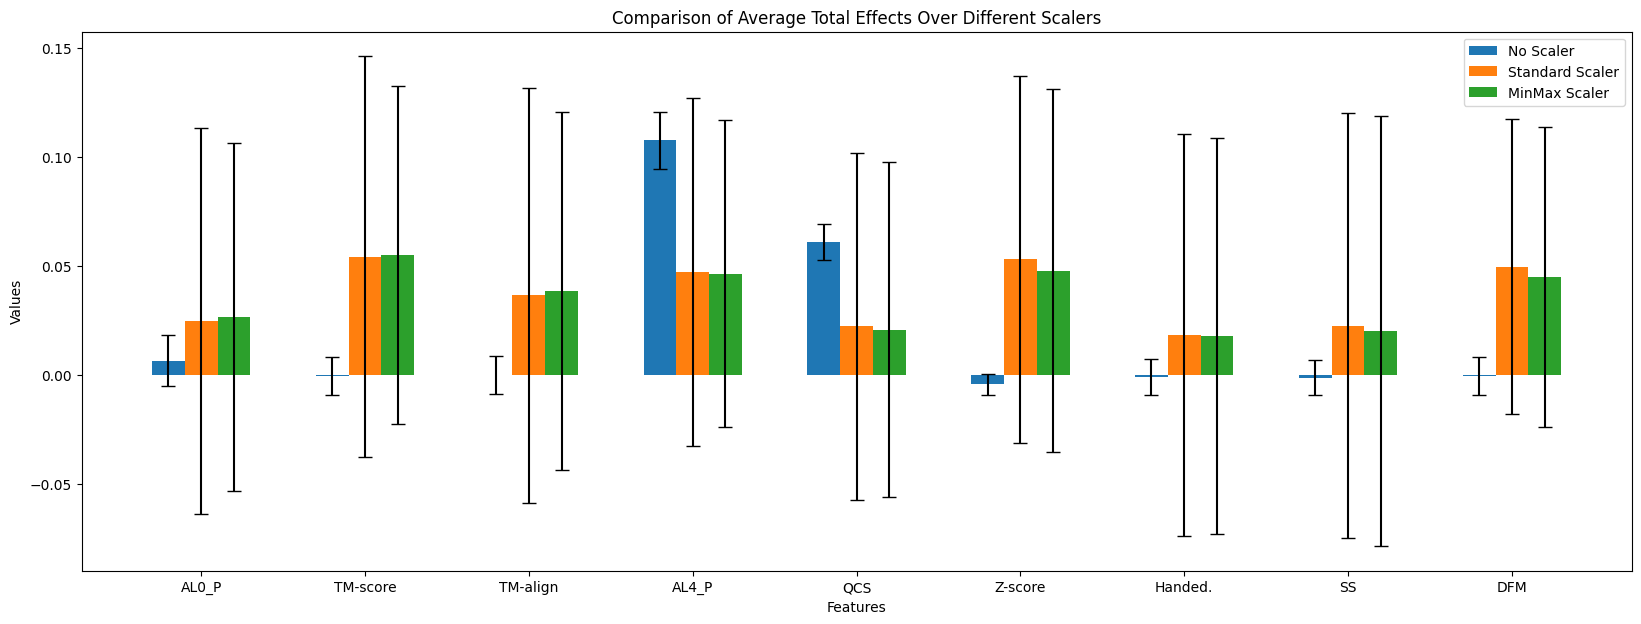

In [31]:
total_effects = pd.read_csv("./total_effects.csv")
total_effects_average_df,main_effects_std_dev_df = average_std(df)

total_effects_ss = pd.read_csv("./total_effects_stdscaler.csv")
total_effects_ss_average_df,main_effects_ss_std_dev_df = average_std(total_effects_ss)

total_effects_mm = pd.read_csv("./total_effects_minmaxscaler.csv")
total_effects_mm_average_df,main_effects_mm_std_dev_df = average_std(total_effects_mm)


fig, ax = plt.subplots(figsize=(20, 7))


bar_width = 0.2
bar_positions = np.arange(len(main_effects_average_df.columns))
ax.bar(bar_positions - bar_width, main_effects_average_df.iloc[0], width=bar_width, yerr=main_effects_std_dev_df.iloc[0], capsize=5, label='No Scaler')
ax.bar(bar_positions, main_effects_ss_average_df.iloc[0], width=bar_width, yerr=main_effects_ss_std_dev_df.iloc[0], capsize=5, label='Standard Scaler')
ax.bar(bar_positions + bar_width, main_effects_mm_average_df.iloc[0], width=bar_width, yerr=main_effects_mm_std_dev_df.iloc[0], capsize=5, label='MinMax Scaler')

ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Comparison of Average Total Effects Over Different Scalers')

ax.set_xticks(bar_positions)
ax.set_xticklabels(main_effects_average_df.columns)
ax.legend()

plt.savefig('Total_effects.pdf', format='pdf', bbox_inches='tight')

plt.show()
